# **Projet : Optimisation**
## **Master 1 ISI - Sorbonne Université**
### **Année universitaire : 2024-2025**

---

### **Module : Optimisation**

**Sujet du projet :**  
**Dimensionnement de stockage embarqué dans un tramway**  

**Membres de l'équipe :**  
- CHEMLI Fayçal  
- BENALI Lounes  
- AMRANI Amira Yasmine  

---

## **Introduction**

Dans le cadre du module **Optimisation**, ce projet vise à mettre en œuvre une démarche d'optimisation pour le dimensionnement d’un système de stockage embarqué dans un tramway.  
L'objectif principal est de minimiser simultanément la **capacité en énergie de la batterie** et la **chute de tension maximale** tout au long du trajet du tramway.  

Le projet est structuré autour de deux étapes clés :  
1. **Simulation Monte-Carlo** : Exploration de l'espace de recherche par échantillonnage massif pour identifier les solutions non dominées selon la méthode de Pareto.  
2. **Optimisation génétique avec NSGA-II** : Implémentation d'un algorithme génétique pour affiner les compromis entre les critères et explorer efficacement l'espace des solutions.  

Ce projet permet ainsi d’appliquer des concepts fondamentaux en optimisation multi-objectifs et de les contextualiser dans un cadre pratique lié aux systèmes ferroviaires.

---


In [1]:
# bibliothèques : 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

# fichiers : 
# from fonctions import *
# from NSGA import * 
# from monte_carlo_iteration import *
# from NSGA2 import *

# Simulation et Calcul des Grandeurs Électriques

Dans cette section, nous procédons au calcul des grandeurs électriques nécessaires pour simuler le fonctionnement du système d’alimentation hybride d’un tramway. Les données de déplacement du train et les propriétés physiques des conducteurs sont utilisées pour calculer :

1. La **puissance mécanique** requise à chaque instant.
2. La **tension aux bornes du train** $V_{train}$, en tenant compte de la résistance équivalente.
3. Les **courants électriques** $I_1$, $I_2$ et les **puissances dissipées** $P_1$, $P_2$ dans les différents éléments du circuit.

---

## Équations utilisées

1. **Résistance équivalente ($R_{eq}$)** :  
   La résistance équivalente entre le train et les deux sous-stations est donnée par la relation :  
   $$
   R_{eq} = \frac{R_1 \cdot R_2}{R_1 + R_2}
   $$  
   où $R_1$ et $R_2$ sont les résistances des portions de ligne aérienne de contact (LAC) et des rails.

2. **Tension aux bornes du train ($V_{train}$)** :  
   La tension est calculée en résolvant l’équation quadratique suivante :  
   $$
   V_{train} = 0.5 \cdot \left(V_{sst} + \sqrt{V_{sst}^2 - 4 \cdot R_{eq} \cdot P}\right)
   $$  
   si le discriminant $\Delta = V_{sst}^2 - 4 \cdot R_{eq} \cdot P$ est positif.

3. **Courants et puissances** :  
   Les courants $I$, $I_1$, $I_2$ et les puissances dissipées dans les sous-stations ($P_1$, $P_2$) sont calculés comme suit :  
   $$
   I = \frac{V_{sst} - V_{train}}{R_{eq}}
   $$
   $$
   I_1 = \frac{V_{sst} - V_{train}}{R_{sst} + R_{LAC_1} + R_{rail_1}}
   $$
   $$
   I_2 = \frac{V_{sst} - V_{train}}{R_{sst} + R_{LAC_2} + R_{rail_2}}
   $$
   Les puissances dissipées sont calculées par :  
   $$
   P_1 = R_{sst} \cdot I_1^2
   $$
   $$
   P_2 = R_{sst} \cdot I_2^2
    $$

In [2]:
# import numpy as np 
# import matplotlib.pyplot as plt
from fonctions import *

# Données du problème
Vsst = 790  
Rsst = 33e-3  
RLAC_per_m = 95e-6  
Rrail_per_m = 10e-6  

# Charger les données de la marche du train
data = np.loadtxt('marche_train.txt')  
temps = data[:, 0]
position_x = data[:, 1] 

Pmechanique = calculer_puissance_mecanique(temps, position_x)



Ptrain = []
for p_mechanique in Pmechanique:
    if p_mechanique >= 0:
        Ptrain.append(p_mechanique / 0.80 + 35000)
    else:
        Ptrain.append(p_mechanique * 0.80 + 35000)
  
  

# 1. Calcul de Vtrain
Vtrain = []
for idx in range(len(temps)):
    x = position_x[idx]
    Req = calculer_Req(x)
    P = Ptrain[idx]
    delta = Vsst**2 - 4 * Req * P
    if delta >= 0:
        V = 0.5 * (Vsst + np.sqrt(delta))
        Vtrain.append(V)
    else:
        Vtrain.append(np.nan)

# 2. Calcul des courants et des puissances (en dehors de la boucle de Vtrain)
i  = []
i1 = []
i2 = []
P1 = []
P2 = []

for idx in range(len(temps)):
    x = position_x[idx]
    Req = calculer_Req(x)
    P = Ptrain[idx]
    V = Vtrain[idx]
    i_value = (Vsst - V) / Req
    i.append(i_value)
    # Calcul des courants i1 et i2
    i1_value = (Vsst - V) / (Rsst + calculer_RLAC(x) + calculer_Rrail(x))
    i2_value = (Vsst - V) / (Rsst + calculer_RLAC(5000 - x) + calculer_Rrail(5000 - x))
    P1_value = (Rsst ) * i1_value**2 
    P2_value = (Rsst ) * i2_value**2 
    i1.append(i1_value)
    i2.append(i2_value)
    P1.append(P1_value)
    P2.append(P2_value)


## Simulation de la tension et la puisance :

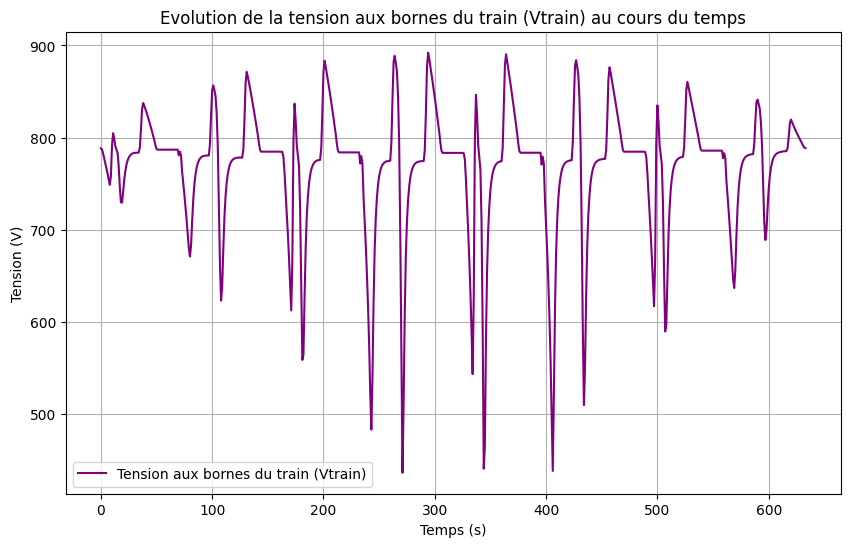

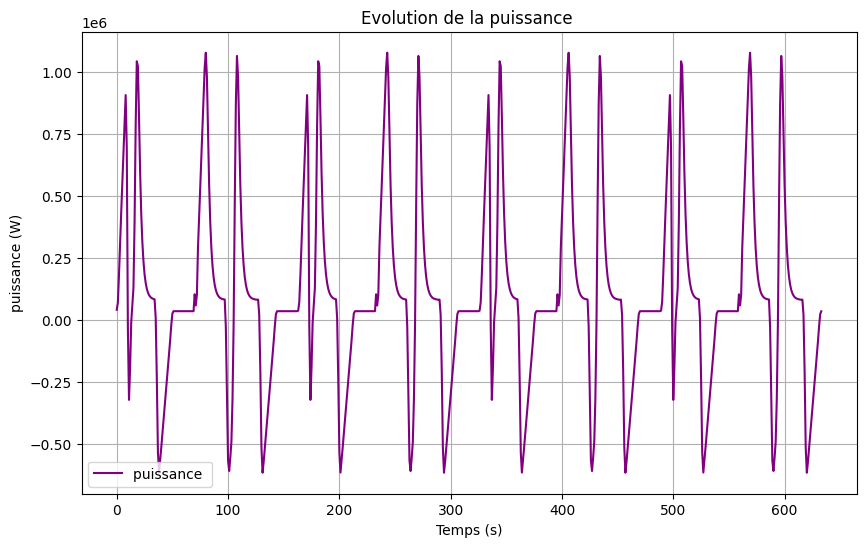

In [3]:
# Tracer les résultats
plt.figure(figsize=(10, 6))
plt.plot(temps, Vtrain, label='Tension aux bornes du train (Vtrain)', color='purple')
plt.title('Evolution de la tension aux bornes du train (Vtrain) au cours du temps')
plt.xlabel('Temps (s)')
plt.ylabel('Tension (V)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(temps, Ptrain, label='puissance ', color='purple')
plt.title('Evolution de la puissance ')
plt.xlabel('Temps (s)')
plt.ylabel('puissance (W)')
plt.legend()
plt.grid(True)
plt.show()



Commentaire : 

## Simulation les courants et la puissance consommée 

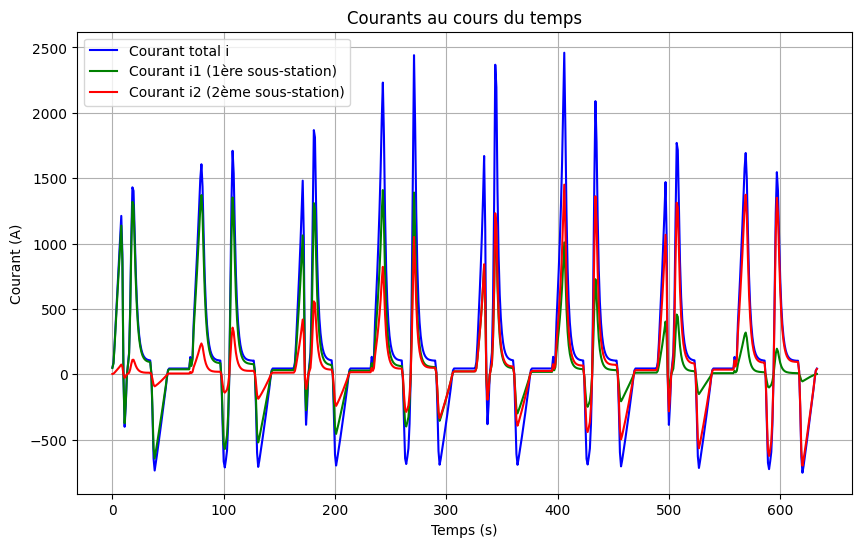

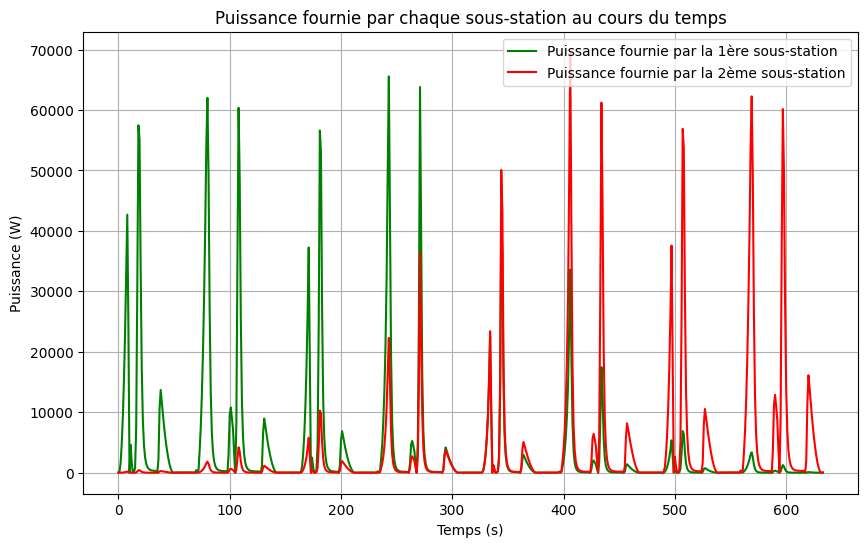

In [4]:
# Tracer les courants (i, i1, i2)
plt.figure(figsize=(10, 6))
plt.plot(temps, i, label='Courant total i', color='blue')
plt.plot(temps, i1, label='Courant i1 (1ère sous-station)', color='green')
plt.plot(temps, i2, label='Courant i2 (2ème sous-station)', color='red')
plt.title('Courants au cours du temps')
plt.xlabel('Temps (s)')
plt.ylabel('Courant (A)')
plt.legend()
plt.grid(True)
plt.show()

# Tracer les puissances (P1 et P2)
plt.figure(figsize=(10, 6))
plt.plot(temps, P1, label='Puissance fournie par la 1ère sous-station', color='green')
plt.plot(temps, P2, label='Puissance fournie par la 2ème sous-station', color='red')
plt.title('Puissance fournie par chaque sous-station au cours du temps')
plt.xlabel('Temps (s)')
plt.ylabel('Puissance (W)')
plt.legend()
plt.grid(True)
plt.show()

Commentaire : 

# Gestion de Puissance dans un Système de Batterie Embarqué

## **Description du Système**

La fonction `gestion_puissances` gère la répartition d'énergie entre :
1. **La batterie** : Fournit ou stocke l'énergie.
2. **La LAC (Ligne Aérienne de Contact)** : Source d'alimentation principale.
3. **Le rhéostat** : Dissipe l'énergie excédentaire.

L’objectif est de répondre à la demande énergétique tout en optimisant l’utilisation de la batterie.

---

## **Principe de Fonctionnement**

### 1. **Demande Élevée ($P_{train} \geq P_{seuil}$)**
- La batterie fournit la puissance manquante :  
  $P_{battery} = \min(P_{train} - P_{seuil}, \min(P_{battery\_output\_capacity}, \frac{battery\_level}{Dt}))$
- La LAC complète si nécessaire :  
  $P_{LAC} = P_{seuil} + (P_{train} - P_{seuil} - P_{battery})$

---

### 2. **Demande Modérée ($0 < P_{train} < P_{seuil}$)**
- La LAC couvre entièrement la demande :  
  $P_{LAC} = P_{train}$
- La batterie et le rhéostat restent inactifs :  
  $P_{battery} = 0$, $P_{rheostat} = 0$

---

### 3. **Récupération d’Énergie ($P_{train} \leq 0$)**
- L’énergie est stockée dans la batterie si possible :  
  $P_{battery} = \max(P_{train}, -\frac{P_{battery\_input\_capacity}}{Dt})$
- Si la batterie est pleine, l’énergie excédentaire est dissipée :  
  $P_{rheostat} = -P_{train}$

---

## **Mise à Jour de la Batterie**

- **Décharge** :  
  $battery\_level -= \frac{P_{battery}}{battery\_efficiency} \cdot Dt$
  
- **Charge** :  
  $battery\_level += -P_{battery} \cdot battery\_efficiency \cdot Dt$

---

## **Sorties de la Fonction**

La fonction retourne :
- $P_{battery}$ : Puissance fournie ou stockée par la batterie.
- $P_{LAC}$ : Puissance fournie par la LAC.
- $P_{rheostat}$ : Puissance dissipée.
- $battery\_level$ : Niveau d’énergie restant dans la batterie.

---

Cette fonction assure une gestion énergétique optimale, en garantissant la continuité du service tout en protégeant la batterie contre les surcharges ou les décharges excessives.


In [5]:

# Parametres du probleme
battery_capacity = 5e6  # en J
P_seuil = 0.5e6 # en W


# Details
battery_level = battery_capacity*0.5     # J
battery_output_capacity = battery_capacity / 10.0  # W
battery_input_capacity = battery_capacity / 10.0   # W
Dt = 1 # en s

# Liste pour stocker les résultats de la batterie
P_battery_list = []
P_LAC_list = []
P_rheostat_list = []
battery_levels = []


# Boucle de simulation pour chaque point de données
for t in range(len(Ptrain)):
    p = Ptrain[t]
    P_battery, P_LAC, P_rheostat, battery_level = gestion_puissances(P_seuil, p, battery_level, battery_capacity, battery_output_capacity, battery_input_capacity, Dt)
    
    P_battery_list.append(P_battery)
    P_LAC_list.append(P_LAC)
    P_rheostat_list.append(P_rheostat)
    battery_levels.append(battery_level)



## Simulation de différentes puissances 

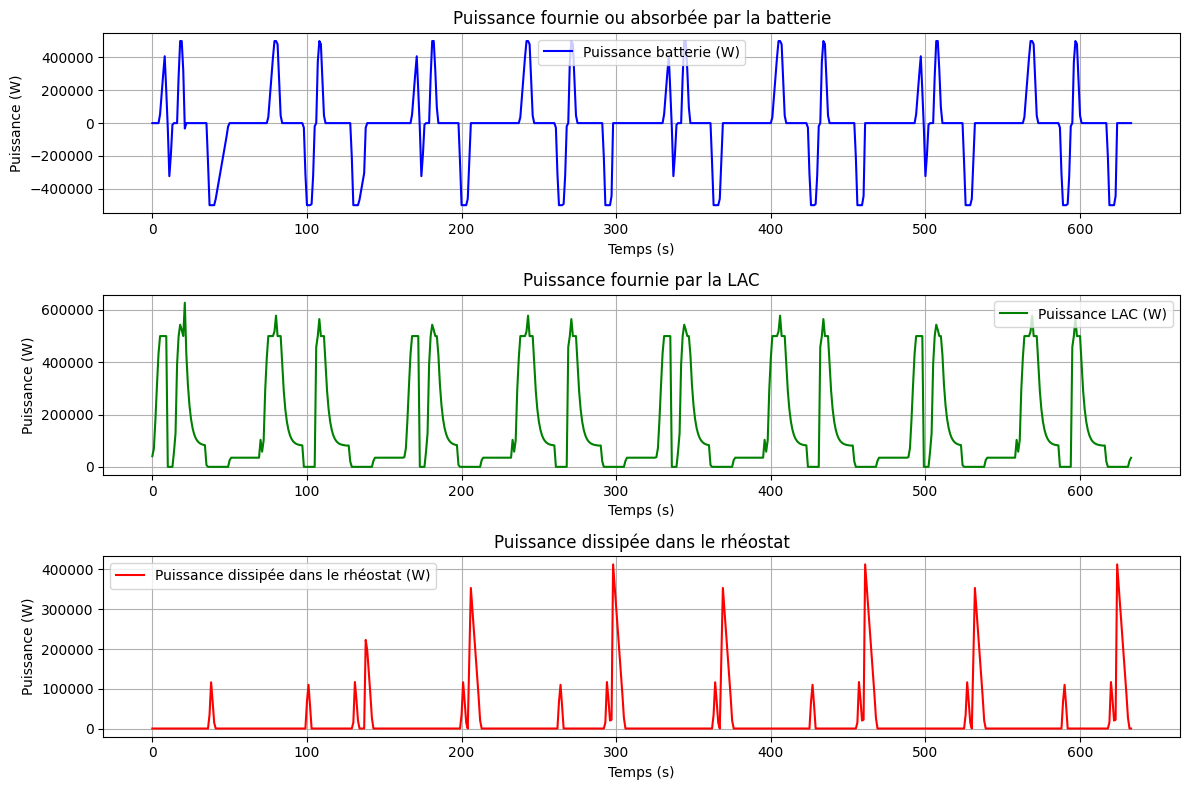

In [6]:
# AFFICHAGE
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(temps, P_battery_list, label='Puissance batterie (W)', color='blue')
plt.title('Puissance fournie ou absorbée par la batterie')
plt.xlabel('Temps (s)')
plt.ylabel('Puissance (W)')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(temps, P_LAC_list, label='Puissance LAC (W)', color='green')
plt.title('Puissance fournie par la LAC')
plt.xlabel('Temps (s)')
plt.ylabel('Puissance (W)')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(temps, P_rheostat_list, label='Puissance dissipée dans le rhéostat (W)', color='red')
plt.title('Puissance dissipée dans le rhéostat')
plt.xlabel('Temps (s)')
plt.ylabel('Puissance (W)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()




## Simulation niveau de la batterie : 

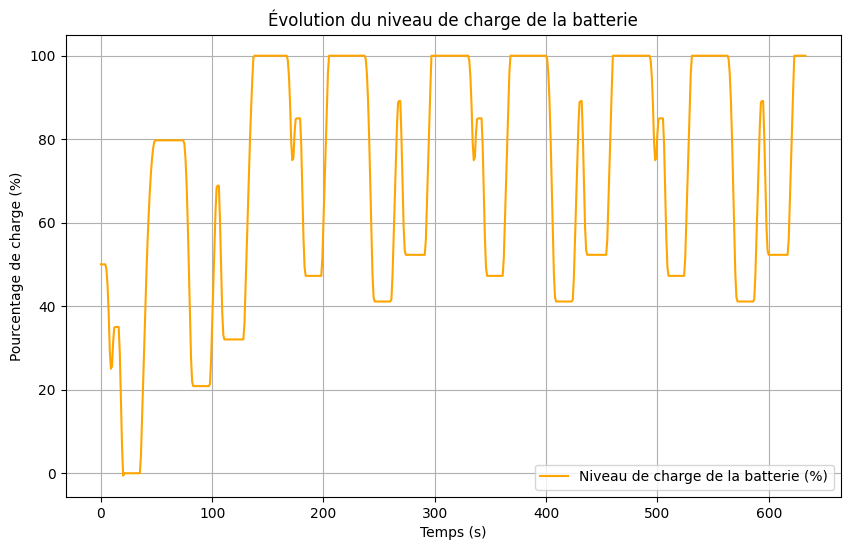

In [7]:
battery_levels_np = np.array(battery_levels)
battery_prctg = 100 * battery_levels_np / battery_capacity

plt.figure(figsize=(10, 6))
plt.plot(temps, battery_prctg, label='Niveau de charge de la batterie (%)', color='orange')
plt.title('Évolution du niveau de charge de la batterie')
plt.xlabel('Temps (s)')
plt.ylabel('Pourcentage de charge (%)')
plt.legend()
plt.grid(True)
plt.show()

# Méthode Monte Carlo

## **Description**

La méthode Monte Carlo est utilisée pour explorer de manière aléatoire les paramètres du système afin d'évaluer ses performances dans divers scénarios. Dans ce projet, elle permet de simuler différents compromis entre :  
- La **capacité de la batterie** ($battery\_capacity$).  
- Le **seuil de puissance** ($P_{seuil}$).  
- La **chute de tension maximale** ($chute\_de\_tension\_max$).  

---

## **Principe de Fonctionnement**

### 1. **Tirage Aléatoire des Paramètres**
À chaque itération, les valeurs des paramètres clés sont tirées aléatoirement dans leurs plages respectives :
- Capacité de batterie :  
  $$
  battery\_capacity \sim \mathcal{U}(capacity\_range[0], capacity\_range[1])
  $$
- Seuil de puissance :  
  $$
  P_{seuil} \sim \mathcal{U}(P\_seuil\_range[0], P\_seuil\_range[1])
  $$

### 2. **Simulation Temporelle**
Pour chaque point de temps, les calculs suivants sont effectués :
- **Gestion des puissances** : Répartition de l'énergie entre la batterie, la LAC et le rhéostat.  
- **Calcul de la tension** : Résolution d’une équation quadratique pour déterminer $V_{train}$.  
- **Chute de tension** : Calculée comme :  
  $$
  chute\_tension = V_{sst} - V_{train}
  $$

### 3. **Résultats de l’Itération**
Pour chaque itération, la **chute de tension maximale** est enregistrée, accompagnée des paramètres tirés ($battery\_capacity$, $P_{seuil}$).

---

## **Résultat Final**

La méthode Monte Carlo retourne un ensemble de solutions explorées, permettant de visualiser les compromis entre :  
- Réduction de la capacité de la batterie.  
- Minimisation de la chute de tension.



In [6]:
# from tqdm import tqdm
from monte_carlo_iteration import *


capacity_range = (0, 50000000)  # in Joules
P_seuil_range = (0, 1000000)     # in Watts
n_iterations = 1000
Dt = 1

# Run Monte Carlo simulation
results = run_monte_carlo(
    n_iterations,
    capacity_range,
    P_seuil_range,
    gestion_puissances,
    temps,
    position_x,
    Ptrain,
    Vsst,
    calculer_Req,
    Dt
)

Monte Carlo Iterations: 100%|██████████| 1000/1000 [00:04<00:00, 213.46it/s]


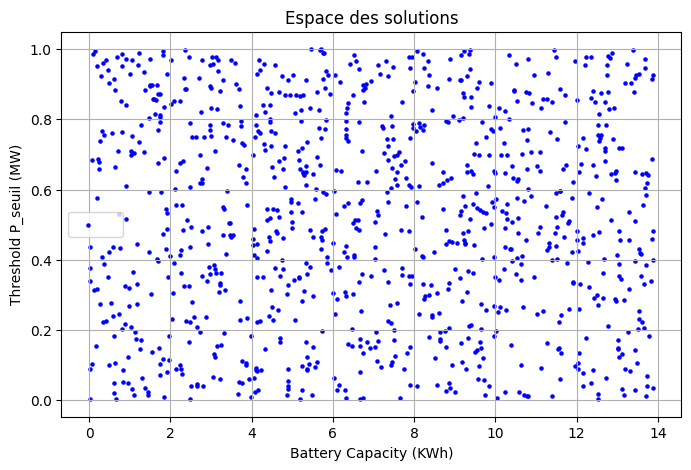

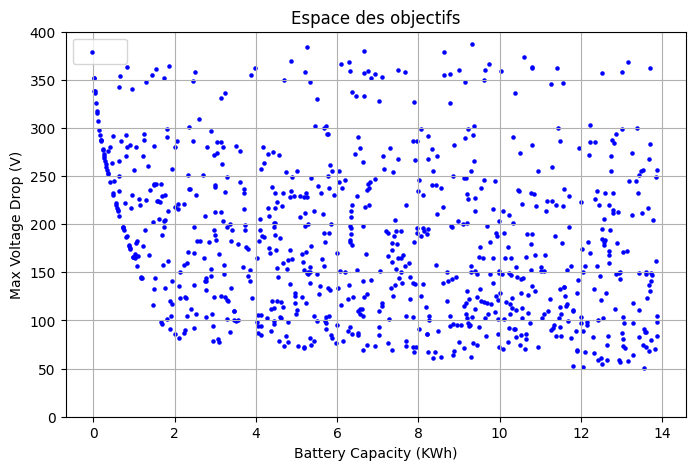

In [7]:
def plot_results(results):
    capacities = [item[0] for item in results]
    p_seuils = [item[1] for item in results]
    voltage_drops = [item[2] for item in results]
    
    capacities_kWh = np.array(capacities) / (3600 * 1000.0)
    p_seuils_MW = np.array(p_seuils) / 1e6
    # -----------------------------------
    # Figure 1: Plot of P_seuil vs. capacity
    # -----------------------------------
    plt.figure(figsize=(8, 5))
    plt.scatter(capacities_kWh, p_seuils_MW, c='blue', s=5, label=' ')
    plt.title("Espace des solutions")
    plt.xlabel("Battery Capacity (KWh)")
    plt.ylabel("Threshold P_seuil (MW)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # -----------------------------------
    # Figure 2: Plot of max voltage drop vs. capacity
    # -----------------------------------
    plt.figure(figsize=(8, 5))
    plt.scatter(capacities_kWh, voltage_drops, c='blue', s=5, label=' ')
    plt.title("Espace des objectifs")
    plt.xlabel("Battery Capacity (KWh)")
    plt.ylabel("Max Voltage Drop (V)")
    plt.ylim(0, 400)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_results(results)


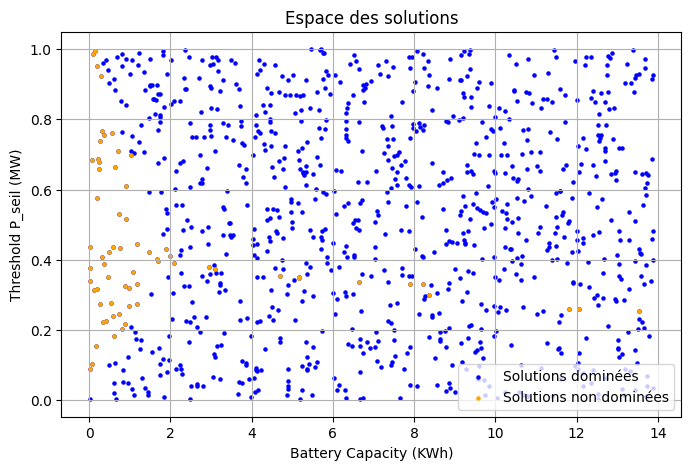

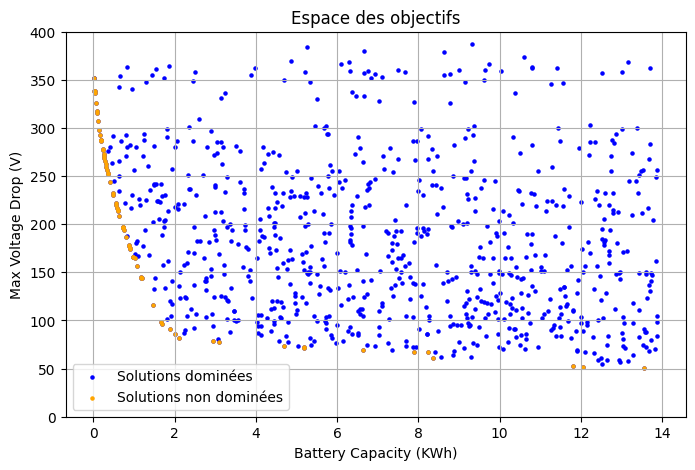

In [8]:
def plot_results(results):
    non_dominated = find_non_dominated_solutions(results)
    
    capacities = [item[0] for item in results]
    p_seuils = [item[1] for item in results]
    voltage_drops = [item[2] for item in results]
    
    non_dom_capacities = [item[0] for item in non_dominated]
    non_dom_p_seuils = [item[1] for item in non_dominated]
    non_dom_voltage_drops = [item[2] for item in non_dominated]
    
    capacities_kWh = np.array(capacities) / (3600 * 1000.0)
    p_seuils_MW = np.array(p_seuils) / 1e6
    non_dom_capacities_kWh = np.array(non_dom_capacities) / (3600 * 1000.0)
    non_dom_p_seuils_MW = np.array(non_dom_p_seuils) / 1e6

    # -----------------------------------
    # Figure 1: Plot of P_seuil vs. capacity
    # -----------------------------------
    plt.figure(figsize=(8, 5))
    # Plot all solutions in blue
    plt.scatter(capacities_kWh, p_seuils_MW, c='blue', s=5, label='Solutions dominées')
    # Plot non-dominated solutions in orange
    plt.scatter(non_dom_capacities_kWh, non_dom_p_seuils_MW, c='orange', s=5, label='Solutions non dominées')
    plt.title("Espace des solutions")
    plt.xlabel("Battery Capacity (KWh)")
    plt.ylabel("Threshold P_seil (MW)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # -----------------------------------
    # Figure 2: Plot of max voltage drop vs. capacity
    # -----------------------------------
    plt.figure(figsize=(8, 5))
    plt.scatter(capacities_kWh, voltage_drops, c='blue', s=5, label='Solutions dominées')
    plt.scatter(non_dom_capacities_kWh, non_dom_voltage_drops, c='orange', s=5, label='Solutions non dominées')
    plt.title("Espace des objectifs")
    plt.xlabel("Battery Capacity (KWh)")
    plt.ylabel("Max Voltage Drop (V)")
    plt.ylim(0, 400)
    plt.grid(True)
    plt.legend()
    plt.show()
0
plot_results(results)

# Optimisation Multi-Objectifs avec NSGA-II

## **Description**

NSGA-II (**Non-dominated Sorting Genetic Algorithm II**) est un algorithme génétique utilisé pour résoudre des problèmes d’optimisation multi-objectifs.  
Dans ce projet, il est implémenté pour minimiser simultanément :
1. **La capacité énergétique de la batterie** ($battery\_capacity$).  
2. **La chute de tension maximale** ($chute\_de\_tension\_max$).  

---

## **Mise en Œuvre avec Pymoo**

### 1. **Définition du Problème**

La classe `BatteryOptimizationProblem` modélise le problème d’optimisation avec :
- **Deux variables de décision** :
  - Capacité de la batterie ($battery\_capacity$).  
  - Seuil de puissance ($P_{seuil}$).  
- **Deux objectifs** :
  - Minimiser la capacité de la batterie.  
  - Minimiser la chute de tension maximale.

Les limites des variables sont définies par :  
$$
0 \leq battery\_capacity \leq 50000000, \quad 0 \leq P_{seuil} \leq 1000000
$$

---

### 2. **Évaluation des Solutions**

Pour chaque solution proposée ($x = [battery\_capacity, P_{seuil}]$), les étapes suivantes sont effectuées :
- Simulation temporelle pour calculer :
  - La chute de tension maximale ($chute\_de\_tension\_max$).
  - L’utilisation énergétique de la batterie.
- Résolution de l’équation quadratique pour déterminer la tension aux bornes du train ($V_{train}$).

---

### 3. **Optimisation avec NSGA-II**

L’algorithme génétique NSGA-II génère une population de solutions et évolue sur plusieurs générations pour identifier un **front de Pareto** optimal.  
Les solutions du front représentent les meilleurs compromis entre :  
- Réduction de la capacité de la batterie.  
- Minimisation de la chute de tension maximale.

---

## **Résultats**

L'implémentation avec **Pymoo** permet :
1. Une exploration efficace des solutions optimales.  
2. La visualisation du front de Pareto, mettant en évidence les compromis entre les deux objectifs.


In [9]:
# from pymoo.core.problem import ElementwiseProblem
# import numpy as np
# from pymoo.algorithms.moo.nsga2 import NSGA2
# from pymoo.optimize import minimize
# import matplotlib.pyplot as plt
from NSGA import *



def visualize_results(results):
    # Pareto front visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(results.F[:, 0], results.F[:, 1], c='blue', label='Solutions')
    plt.xlabel('Battery Capacity (J)')
    plt.ylabel('Maximum Voltage Drop (V)')
    plt.title('Pareto Front of Battery Optimization')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Solutions distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.hist(results.X[:, 0], bins=30)
    ax1.set_xlabel('Battery Capacity (J)')
    ax1.set_ylabel('Count')
    ax1.set_title('Distribution of Battery Capacity')

    ax2.hist(results.X[:, 1], bins=30)
    ax2.set_xlabel('P_seuil (W)')
    ax2.set_ylabel('Count')
    ax2.set_title('Distribution of P_seuil')
    
    plt.tight_layout()
    plt.show()

def run_nsga2_optimization(temps, position_x, Ptrain, Vsst, calculer_Req, Dt, gestion_puissances):
    problem = BatteryOptimizationProblem(
        temps, position_x, Ptrain, Vsst, calculer_Req, Dt, gestion_puissances
    )

    algorithm = NSGA2(
        pop_size=100,
        n_offsprings=100
    )

    termination = ('n_gen', 100)

    res = minimize(
        problem,
        algorithm,
        termination,
        seed=1,
        save_history=True,
        verbose=True
    )

    visualize_results(res)
    
    return res


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     19 |             - |             -
     2 |      200 |     34 |  0.0045024848 |         ideal
     3 |      300 |     58 |  0.0117165895 |             f
     4 |      400 |    100 |  0.0055055310 |             f
     5 |      500 |    100 |  0.0123891779 |         ideal
     6 |      600 |    100 |  0.0148618903 |         ideal
     7 |      700 |    100 |  0.0019145156 |             f
     8 |      800 |    100 |  0.0026155922 |             f
     9 |      900 |    100 |  0.0032923186 |             f
    10 |     1000 |    100 |  0.0016458287 |             f
    11 |     1100 |    100 |  0.0032523421 |             f
    12 |     1200 |    100 |  0.0016024296 |             f
    13 |     1300 |    100 |  0.0029863798 |             f
    14 |     1400 |    100 |  0.0014082713 |             f
    15 |     1500 |    100 |  0.0030895518 |             f
    16 |     1600 |    100 |  0.0017854653 |            

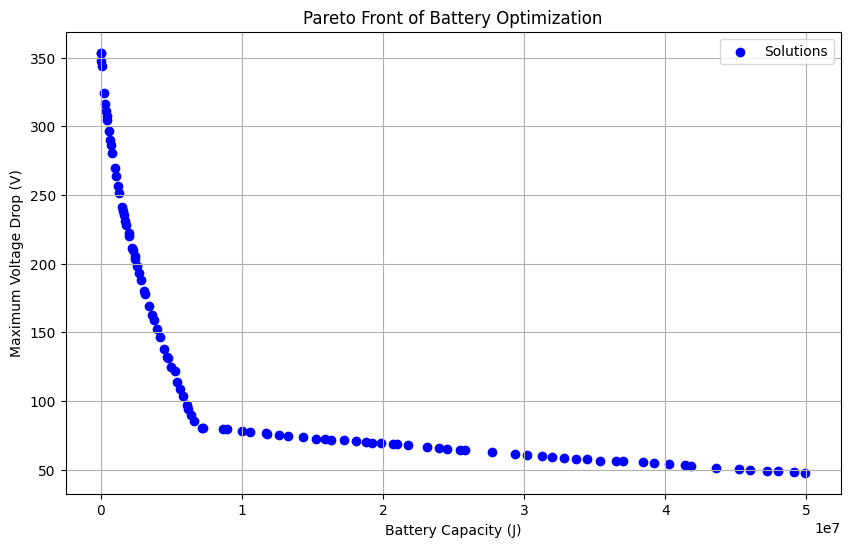

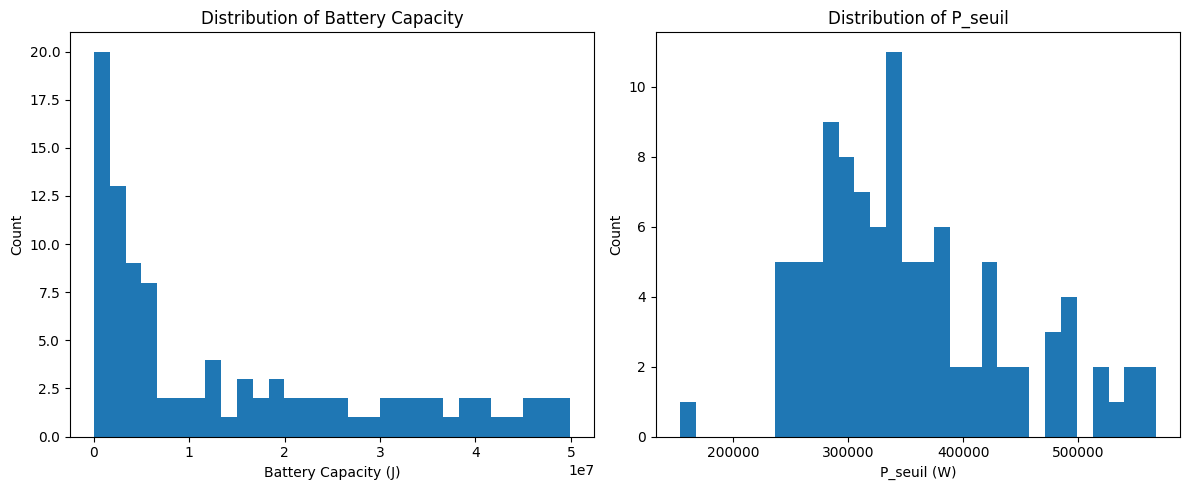

In [10]:
# from NSGA import *
# Utilsation du code précédent
results = run_nsga2_optimization(
    temps,
    position_x,
    Ptrain,
    Vsst,
    calculer_Req,
    Dt,
    gestion_puissances
)

# Optimisation Multi-Objectifs : NSGA-II Implémenté à Partir de Zéro

## **Description**

Cette méthode implémente **NSGA-II** sans utiliser de bibliothèque externe. L'algorithme est conçu pour minimiser simultanément :
1. **La capacité énergétique de la batterie**.  
2. **La chute de tension maximale**.  

---

## **Mise en Œuvre**

### 1. **Modélisation avec la Classe `Individu`**

Chaque solution est représentée par un individu contenant :
- **Variables de décision** ($x = [battery\_capacity, P_{seuil}]$).  
- **Objectifs** : $[battery\_capacity, chute\_de\_tension\_max]$.  
- **Rang** : Défini par la domination de Pareto.  
- **Distance de Crowding** : Mesure la diversité des solutions proches sur le front.

---

### 2. **Étapes de NSGA-II**

#### a. **Initialisation**
- Une population initiale est générée aléatoirement dans les limites des variables :  
  $0 \leq battery\_capacity \leq 50000000$,  
  $0 \leq P_{seuil} \leq 1000000$.

#### b. **Évaluation des Individus**
- Chaque individu est évalué en simulant le comportement du système pour calculer les objectifs.

#### c. **Tri Non Dominé**
- Les individus sont classés en fronts selon la méthode de Pareto :
  - Un individu domine un autre s’il est meilleur sur tous les objectifs et strictement meilleur sur au moins un.

#### d. **Création des Descendants**
- **Sélection par tournoi** : Les meilleurs individus sont sélectionnés pour la reproduction.  
- **Croisement** : Les variables des parents sont combinées pour générer de nouveaux individus.  
- **Mutation** : De petites variations aléatoires sont appliquées pour explorer de nouvelles solutions.

#### e. **Sélection de la Nouvelle Génération**
- Les individus des fronts non dominés sont ajoutés à la nouvelle population jusqu’à atteindre la taille requise.
- Les individus restants sont triés par **distance de crowding** pour maintenir la diversité.

---

## **Résultats**

1. **Domaine de Recherche** :  
   Les solutions générées couvrent un large espace des paramètres ($battery\_capacity$, $P_{seuil}$).

2. **Front de Pareto** :  
   Les solutions non dominées révèlent les compromis entre :
   - Réduction de la capacité de la batterie.  
   - Minimisation de la chute de tension.

---

## **Visualisation**

### a. Domaine de Recherche :
Un graphe montre les solutions générées dans l’espace des variables de décision ($battery\_capacity$, $P_{seuil}$).

### b. Front de Pareto :
Un graphe illustre les meilleurs compromis trouvés entre les objectifs ($battery\_capacity$, $chute\_de\_tension\_max$).

---

Cette implémentation manuelle de NSGA-II offre une flexibilité complète pour analyser et optimiser les performances du système.


Génération 0
Génération 10
Génération 20
Génération 30
Génération 40
Génération 50
Génération 60
Génération 70
Génération 80
Génération 90


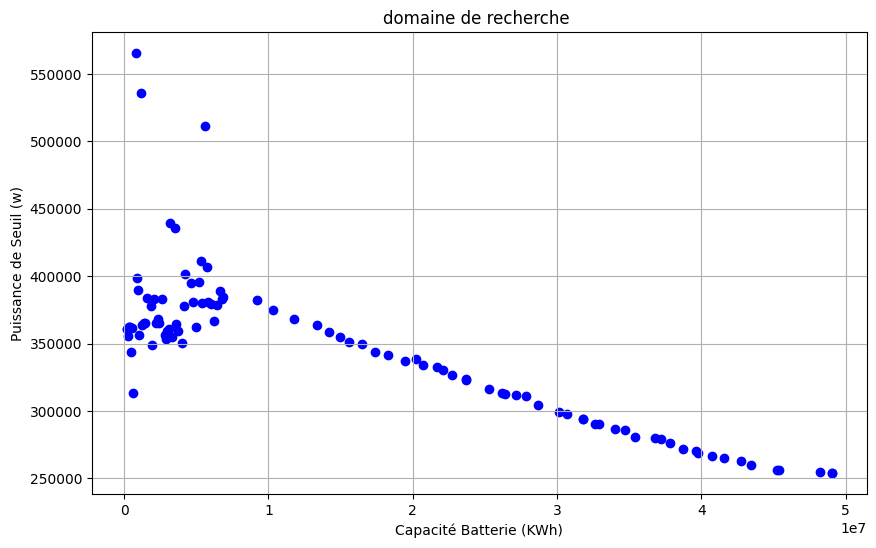

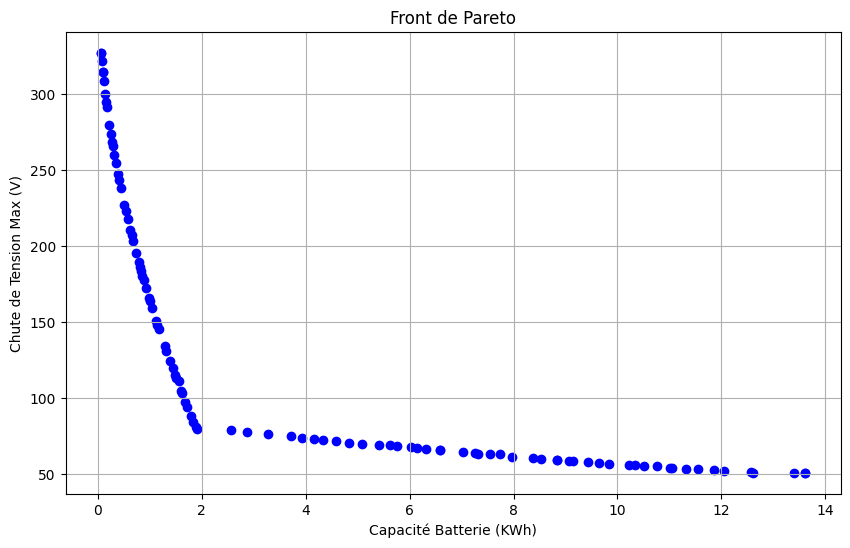

In [11]:
# Utilisation du code précedent pour appliquer NSGA2
# import random
from NSGA2 import *
 


bornes = [(0, 50000000), (0, 1000000)]
parametres_probleme = {
    'temps': temps,
    'position_x': position_x,
    'Ptrain': Ptrain,
    'Vsst': Vsst,
    'calculer_Req': calculer_Req,
    'Dt': Dt,
    'gestion_puissances': gestion_puissances
}

population_finale = nsga2(
    parametres_probleme=parametres_probleme,
    taille_pop=100,
    nb_generations=100,
    bornes=bornes
)

afficher_resultats(population_finale)
